In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import torch
import numpy as np

In [2]:
model = YOLO("yolov8n.yaml")


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [3]:
model

In [4]:
model = torch.load('best.pt')
model.keys()

dict_keys(['epoch', 'best_fitness', 'model', 'ema', 'updates', 'optimizer', 'train_args', 'date', 'version'])

In [5]:
# model['model'].to(torch.float32)

In [6]:
model

{'epoch': -1,
 'best_fitness': None,
 'model': DetectionModel(
   (model): Sequential(
     (0): Conv(
       (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (1): Conv(
       (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (2): C2f(
       (cv1): Conv(
         (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
         (act): SiLU(inplace=True)
       )
       (cv2): Conv(
         (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track

In [7]:
from PIL import Image
import cv2

(1200, 675)


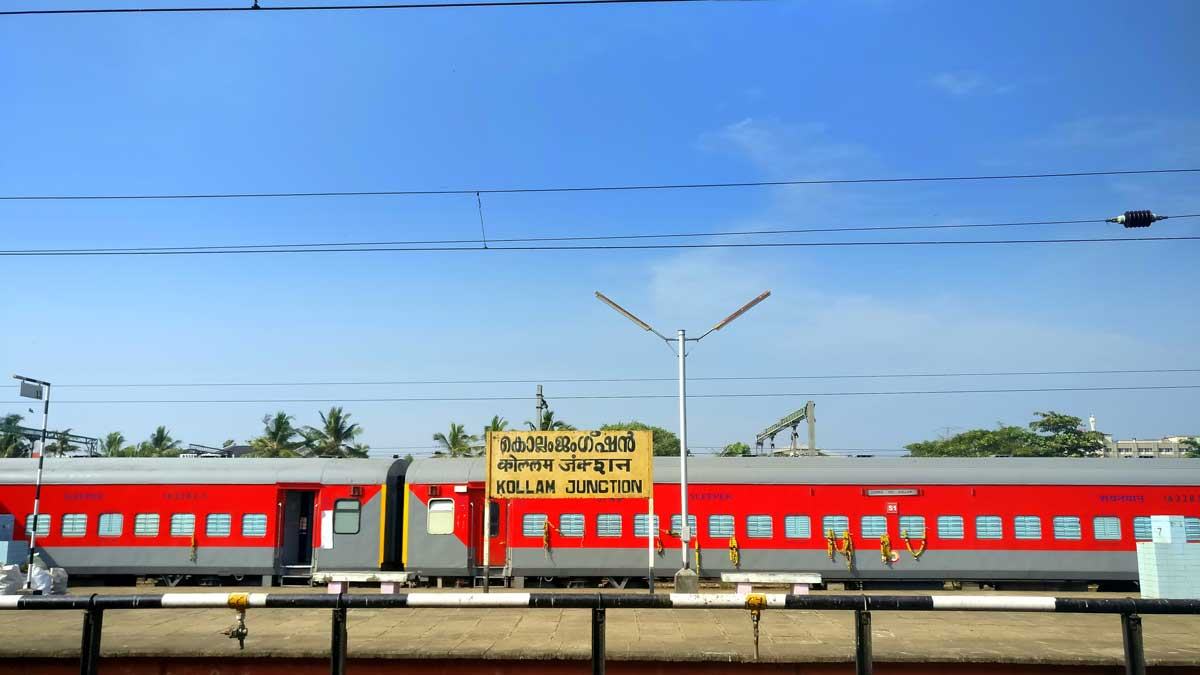

In [8]:
im = Image.open('test3.jpeg')
print(im.size)
im

In [9]:
imcv = cv2.imread('test3.jpeg')
imcv.shape

(675, 1200, 3)

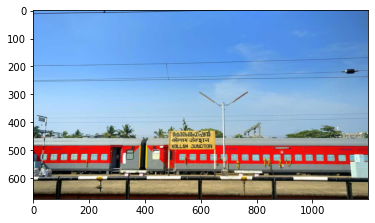

In [10]:
show_cv = lambda x: plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
show_cv(imcv)

In [11]:
sz = imcv.shape
new_sz = (640, 640, 3)
sz, new_sz

((675, 1200, 3), (640, 640, 3))

In [12]:
ratio = min(new_sz[0]/sz[0], new_sz[1]/sz[1])
ratio

0.5333333333333333

In [13]:
mid_sz = (int(sz[1]*ratio), int(sz[0]*ratio))
mid_sz

(640, 360)

In [14]:
pd_sz = (new_sz[0]-mid_sz[0], new_sz[1]-mid_sz[1])
pd_sz

(0, 280)

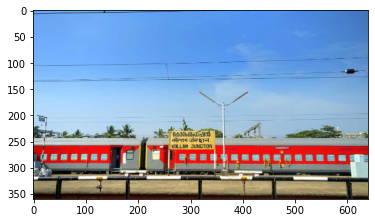

In [15]:
mid_img = cv2.resize(imcv, mid_sz,interpolation=cv2.INTER_LINEAR)
show_cv(mid_img)

In [16]:
top, bottom = int(round(pd_sz[1]/2 + 0.1)), int(round(pd_sz[1]/2 - 0.1))
left, right = int(round(pd_sz[0]/2 + 0.1)), int(round(pd_sz[0]/2 - 0.1))
top, bottom, left, right

(140, 140, 0, 0)

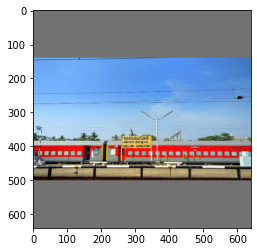

In [17]:
final = cv2.copyMakeBorder(mid_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(114, 114, 114))
show_cv(final)

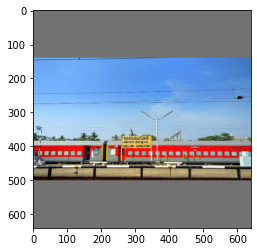

In [18]:
def pretransform(im, resized_sz = (640, 640)):
    sz = im.shape
    new_sz = resized_sz
    ratio = min(new_sz[0]/sz[0], new_sz[1]/sz[1])
    mid_sz = (int(sz[1]*ratio), int(sz[0]*ratio))
    pd_sz = (new_sz[0]-mid_sz[0], new_sz[1]-mid_sz[1])
    mid_img = cv2.resize(im, mid_sz,interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(pd_sz[1]/2 + 0.1)), int(round(pd_sz[1]/2 - 0.1))
    left, right = int(round(pd_sz[0]/2 + 0.1)), int(round(pd_sz[0]/2 - 0.1))
    final = cv2.copyMakeBorder(mid_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(114, 114, 114))
    return final


show_cv(pretransform(imcv))


In [19]:
model_data = [pretransform(imcv)]
model_data = [i for i in model_data]

In [20]:
data_t = np.stack(model_data)
data_t.shape

(1, 640, 640, 3)

In [21]:
# BGR to RGB, BHWC to BCHW, (n, 3, h, w)
data_transpose = data_t[..., ::-1].transpose(0, 3, 1, 2)
print(data_transpose.shape)
data_transpose = np.ascontiguousarray(data_transpose)
print(data_transpose.shape)

(1, 3, 640, 640)
(1, 3, 640, 640)


In [22]:
data_tensor = torch.from_numpy(data_transpose)
data_tensor.shape

torch.Size([1, 3, 640, 640])

In [23]:
def preprocess(files):
    ims = [cv2.imread(f) for f in files]
    t_ims = [pretransform(im) for im in ims]
    data = np.stack(t_ims)
    data_transpose = data[..., ::-1].transpose(0, 3, 1, 2)
    data_transpose = np.ascontiguousarray(data_transpose)
    data_tensor = torch.from_numpy(data_transpose)
    return data_tensor.to(torch.float32)/255, ims

model_input, orig_img = preprocess(['test3.jpeg', 'test2.jpeg'])
model_input.shape

torch.Size([2, 3, 640, 640])

In [24]:
model_input[0].transpose(0, 2).transpose(0, 1).flip(dims=(2,)).numpy().shape

(640, 640, 3)

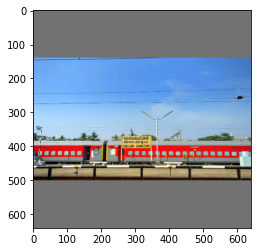

In [25]:
show_cv2 = lambda x: plt.imshow(cv2.cvtColor((x.transpose(0, 2).transpose(0, 1).flip(dims=(2,)).float()).numpy(), cv2.COLOR_BGR2RGB))
show_cv2(model_input[0])

In [26]:
# model['model'].full()

In [27]:
preds = model['model'].to(torch.float32)(model_input)

In [28]:
len(preds)

2

In [29]:
preds[0].shape, preds[1][0].shape

(torch.Size([2, 5, 8400]), torch.Size([2, 65, 80, 80]))

In [30]:
preds[0][0][0]

tensor([  4.6522,  19.3779,  25.9292,  ..., 538.4293, 556.5343, 589.7338])

In [31]:
preds[1][0][0][0][0]

tensor([ 8.5625,  4.0093,  1.5832,  0.3888, -1.4864, -2.1167, -3.2498, -3.8734, -3.9094, -3.6879, -3.3441, -3.0850, -2.9742, -2.7760, -2.5641, -2.4159, -2.3917, -2.2984, -2.2064, -2.1341, -2.1204, -2.0812, -2.0430, -2.0119, -1.9926, -1.9819, -1.9712, -1.9544, -1.9381, -1.9218, -1.9008, -1.8743, -1.8610, -1.8384,
        -1.8153, -1.7930, -1.7801, -1.7583, -1.7375, -1.7163, -1.7026, -1.6961, -1.6901, -1.6837, -1.6768, -1.6644, -1.6529, -1.6431, -1.6381, -1.6316, -1.6262, -1.6232, -1.6174, -1.6113, -1.6116, -1.6214, -1.6258, -1.6140, -1.5965, -1.5939, -1.6134, -1.6574, -1.7100, -1.7578, -1.8280, -1.9685, -2.1191, -2.1967,
        -2.2788, -2.5258, -2.8014, -3.0548, -3.1131, -3.1513, -3.0279, -2.9387, -2.2662, -1.5836, -0.7947, -0.6372])

In [32]:
from ultralytics.yolo.utils.ops import non_max_suppression

In [33]:
results = non_max_suppression(
    preds,
    conf_thres=0.40,
    iou_thres=0.2,
    max_det=10,
    nc=1
)

In [34]:
len(results)

2

In [35]:
results[0].shape

torch.Size([7, 6])

In [36]:
results[0][6]

tensor([317.0861, 384.6333, 338.0140, 393.5322,   0.4253,   0.0000])

In [37]:
orig_shape = orig_img[0].shape[:-1]
img_shape = model_input[0].shape[1:]
orig_shape, img_shape

((675, 1200), torch.Size([640, 640]))

In [38]:
gain = min(img_shape[0]/orig_shape[0], img_shape[1]/orig_shape[1])
pad = (img_shape[0] - orig_shape[0] * gain)/2, (img_shape[1] - orig_shape[1] * gain)/2
gain, pad

(0.5333333333333333, (140.0, 0.0))

In [39]:
box = results[0]
box[0]

tensor([264.7670, 383.8834, 295.5536, 391.9049,   0.6386,   0.0000])

In [40]:
box.shape

torch.Size([7, 6])

In [41]:
# box[..., [0, 2]] -= pad[0]
# box[..., [1, 3]] -= pad[1]
# box[0]

In [42]:
# box[..., :4] /= gain
# box[0]

In [43]:
gain

0.5333333333333333

(496, 457) (554, 472)
(559, 458) (588, 472)
(607, 478) (641, 493)
(496, 478) (557, 493)
(564, 478) (607, 493)
(500, 433) (632, 452)
(594, 458) (633, 475)
88888888888888888888888888888888888888888888888888
(77, 150) (405, 216)
(61, 225) (417, 285)
(41, 80) (412, 146)
(81, 417) (160, 476)
88888888888888888888888888888888888888888888888888


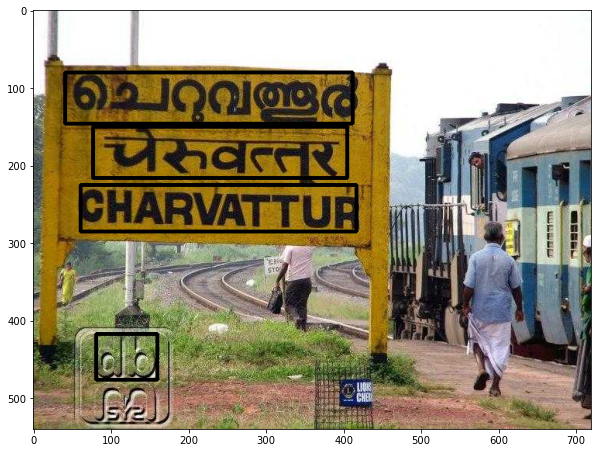

In [44]:
boxes = results.copy()
for i, box in enumerate(boxes):
    orig_shape = orig_img[i].shape[:-1]
    img_shape = model_input[i].shape[1:]
    gain = min(img_shape[0]/orig_shape[0], img_shape[1]/orig_shape[1])
    pad = (img_shape[0] - orig_shape[0] * gain)/2, (img_shape[1] - orig_shape[1] * gain)/2
    box[..., [0, 2]] -= pad[1]
    box[..., [1, 3]] -= pad[0]
    box[..., :4] /= gain
    imd = orig_img[i].copy()
    # print(gain)
    # print(box)
    box[..., 0].clamp_(0, orig_shape[1])  # x1
    box[..., 1].clamp_(0, orig_shape[0])  # y1
    box[..., 2].clamp_(0, orig_shape[1])  # x2
    box[..., 3].clamp_(0, orig_shape[0])  # y2
    # print(imd.shape)
    for i in box:
        # print(i)    
        start = (int(i[0]), int(i[1]))
        end = (int(i[2]), int(i[3]))
        print(start, end)
        imd = cv2.rectangle(imd, start, end, color=1, thickness=4)
    plt.figure(figsize=(10, 10))
    show_cv(imd)
    # plt.show()
    print('8'*50)

In [45]:
input_names = [ "actual_input" ]
output_names = [ "output" ]
dummy_input = model_input
export_model = model['model'].to(torch.float32).eval()
torch.onnx.export(export_model,
                 dummy_input,
                 "yolo_text.onnx",
                 verbose=False,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True,
                 )

/Users/tnluser/opt/anaconda3/lib/python3.9/site-packages/ultralytics/nn/tasks.py:207: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if augment:
/Users/tnluser/opt/anaconda3/lib/python3.9/site-packages/ultralytics/nn/tasks.py:58: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if profile:
/Users/tnluser/opt/anaconda3/lib/python3.9/site-packages/ultralytics/nn/tasks.py:62: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant 

In [46]:
# from pytorch2keras.converter import pytorch_to_keras

In [ ]:
import onnx

from onnx_tf.backend import prepare

onnx_model = onnx.load("yolo_text.onnx")  # load onnx model
tf_rep = prepare(onnx_model)  # prepare tf representation
tf_rep.export_graph("model_text")  # export the model

In [1]:
tensorflowjs_converter --input_format=tf_saved_model 
--output_format=tfjs_graph_model --saved_model_tags=serve model_text model_text_js

(958, 1556) (2089, 1883)


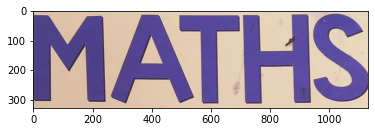

(1313, 1299) (2261, 1543)


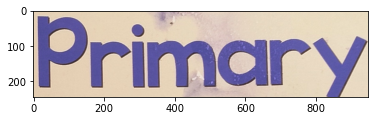

(954, 1306) (1267, 1550)


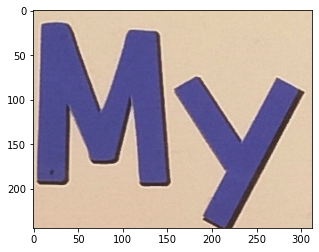

(961, 1884) (2355, 2132)


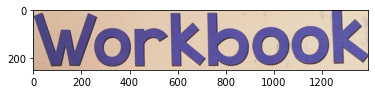

(541, 3305) (676, 3490)


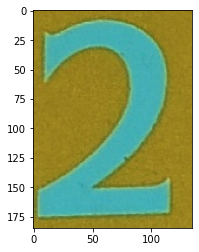

(2125, 2415) (2402, 2472)


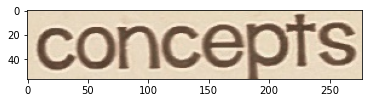

(390, 2733) (870, 2807)


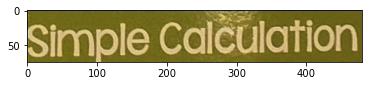

(682, 1211) (857, 1262)


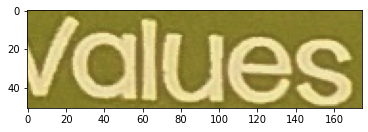

(467, 3017) (789, 3076)


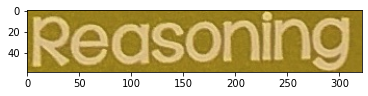

(527, 1455) (735, 1507)


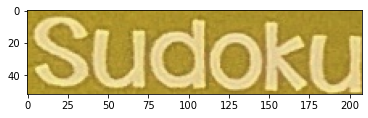

88888888888888888888888888888888888888888888888888
(3154, 1031) (3617, 1274)


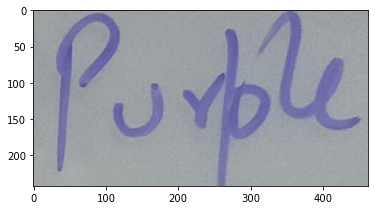

(1201, 1382) (1550, 1686)


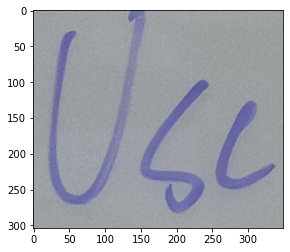

(1505, 771) (1791, 1023)


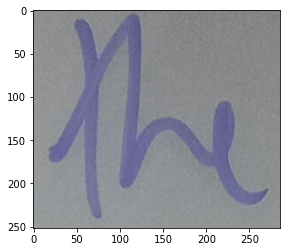

(1689, 1395) (2394, 1697)


(3093, 765) (3294, 923)


(629, 362) (714, 426)


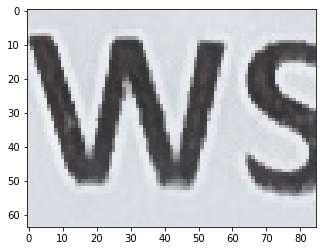

(686, 282) (778, 346)


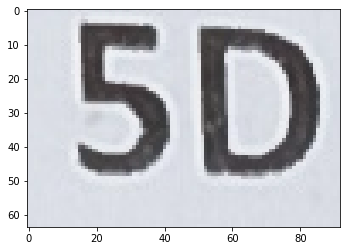

(3669, 1042) (4047, 1284)


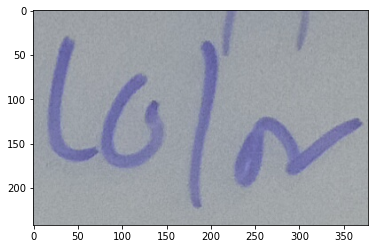

(1857, 799) (2411, 1041)


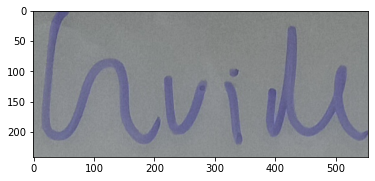

(3192, 1285) (4171, 1512)


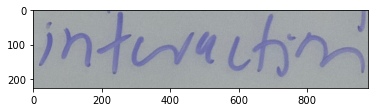

88888888888888888888888888888888888888888888888888
(2722, 971) (3299, 1110)


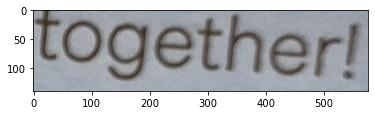

(2364, 957) (2693, 1084)


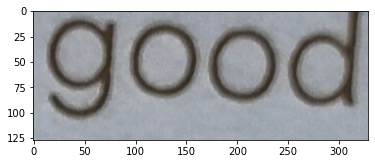

(1757, 905) (2074, 1025)


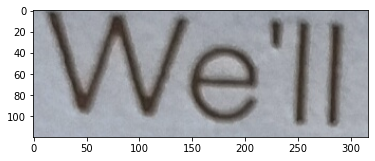

(2089, 918) (2347, 1047)


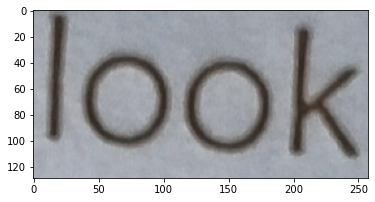

88888888888888888888888888888888888888888888888888
(408, 291) (438, 310)


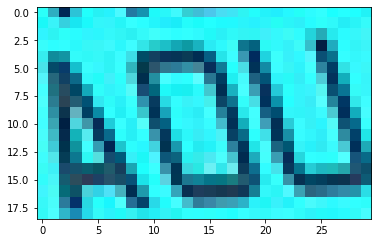

(0, 57) (32, 84)


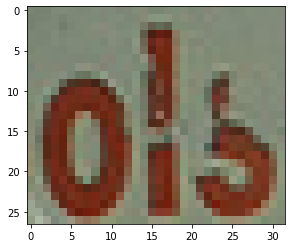

(395, 275) (437, 294)


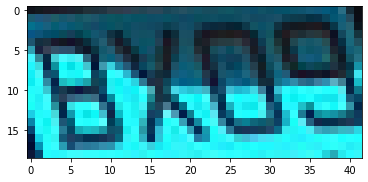

(410, 216) (442, 226)


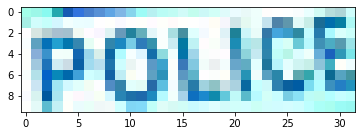

(320, 130) (361, 143)


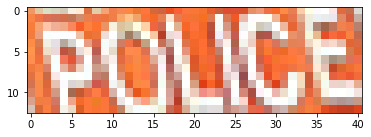

(279, 52) (327, 66)


(29, 215) (50, 225)


88888888888888888888888888888888888888888888888888
(286, 175) (361, 210)


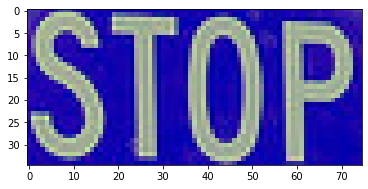

(297, 212) (349, 225)


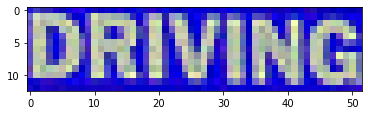

(279, 102) (329, 118)


88888888888888888888888888888888888888888888888888
(156, 262) (306, 317)


(194, 367) (252, 410)


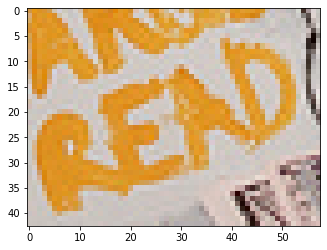

(244, 331) (293, 368)


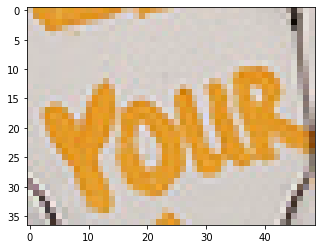

(271, 40) (307, 61)


(292, 321) (348, 356)


(254, 9) (314, 40)


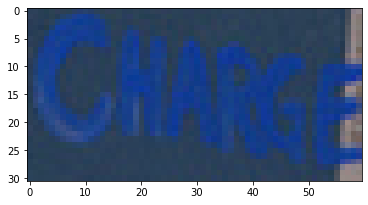

(254, 59) (306, 81)


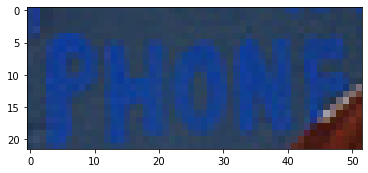

(224, 293) (257, 311)


(262, 347) (345, 391)


(222, 290) (337, 339)


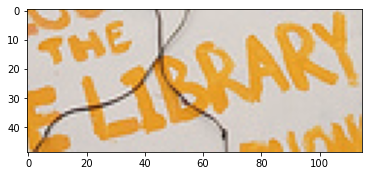

88888888888888888888888888888888888888888888888888
(180, 119) (275, 173)


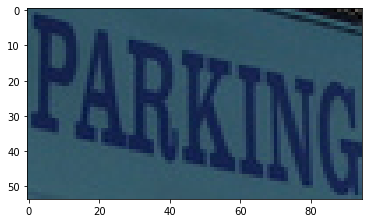

88888888888888888888888888888888888888888888888888


In [57]:
def create_model_boxes(images):
    model_input, orig_img = preprocess(images)
    preds = model['model'].to(torch.float32)(model_input)
    results = non_max_suppression(
        preds,
        conf_thres=0.40,
        iou_thres=0.2,
        max_det=10,
        nc=1
    )
    boxes = results.copy()
    for im_i, box in enumerate(boxes):
        orig_shape = orig_img[im_i].shape[:-1]
        img_shape = model_input[im_i].shape[1:]
        gain = min(img_shape[0]/orig_shape[0], img_shape[1]/orig_shape[1])
        pad = (img_shape[0] - orig_shape[0] * gain)/2, (img_shape[1] - orig_shape[1] * gain)/2
        box[..., [0, 2]] -= pad[1]
        box[..., [1, 3]] -= pad[0]
        box[..., :4] /= gain
        imd = orig_img[im_i].copy()
        # print(gain)
        # print(box)
        box[..., 0].clamp_(0, orig_shape[1])  # x1
        box[..., 1].clamp_(0, orig_shape[0])  # y1
        box[..., 2].clamp_(0, orig_shape[1])  # x2
        box[..., 3].clamp_(0, orig_shape[0])  # y2
        # print(imd.shape)
        for nu, i in enumerate(box):
            # print(i)    
            start = (int(i[0]), int(i[1]))
            end = (int(i[2]), int(i[3]))
            print(start, end)
            text_img = imd[start[1]:end[1], start[0]:end[0]]
            plt.imshow(text_img)
            plt.show()
            cv2.imwrite(f'../datasets/detect_val_data/_{im_i}-{nu}_.jpg', text_img) 
            
            
            # imd = cv2.rectangle(imd, start, end, color=1, thickness=4)
        # plt.figure(figsize=(10, 10))
        # show_cv(imd)
        # plt.show()
        print('8'*50)
        
import os
files = os.listdir('../datasets/yolo_val_data/')
create_model_boxes(['../datasets/yolo_val_data/' + f for f in files])

In [47]:
import os
os.listdir('../datasets/yolo_val_data/')

['IMG20230531111536.jpg',
 'IMG20230531111527.jpg',
 'IMG20230531113625.jpg',
 '4.jpg',
 '2.jpg',
 '3.jpg',
 '1.jpg']